<a href="https://colab.research.google.com/github/Sievv/AMPs-against-KP/blob/main/KP_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare & Split Raw Data(Data Active 138 & Inactive 373)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/KP'


Mounted at /content/drive


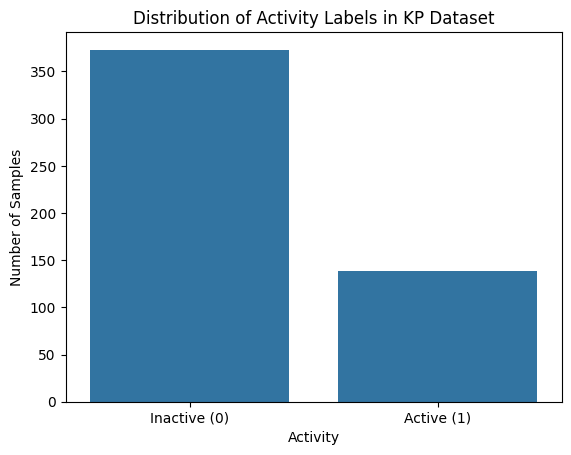

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_active = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/Klebsiella_active_138.csv')
df_inactive = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/Inactive 373.csv')

# Combine datasets
df_kp = pd.concat([df_active, df_inactive], ignore_index=True)

# Plot activity label distribution
counts = df_kp['Activity'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values)
plt.xticks([0, 1], ['Inactive (0)', 'Active (1)'])
plt.ylabel('Number of Samples')
plt.title('Distribution of Activity Labels in KP Dataset')
plt.show()


In [35]:
# Combine datasets
df_combined = pd.concat([df_active, df_inactive], ignore_index=True)

# Shuffle the combined dataframe
df_shuffled = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the shuffled data
print(df_shuffled.head())
print(df_shuffled['Activity'].value_counts())


                                            Sequence  Activity
0                     NCNFLCKVKQRLRSVSSTSHIGMAIPRPRG         1
1                               KRVNWRKVGLGASYVMSWLG         1
2            TAKEAKEKAKETALAATEKAKDLASKAATKKQQQQQQFV         0
3  VCIIFAIMARFYTYINPAEIEAQFDEDEKKKGVGKENPYSSLEPVS...         0
4                               GFCWYVCYRNGVRVCYRRCN         1
Activity
0    373
1    138
Name: count, dtype: int64


In [36]:
# Split into 80% train and 20% test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_shuffled, test_size=0.2, stratify=df_shuffled['Activity'], random_state=42)

# Check sizes
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Optional: check label distribution
print("Train label distribution:")
print(train_df['Activity'].value_counts(normalize=True))
print("Test label distribution:")
print(test_df['Activity'].value_counts(normalize=True))

Training set size: 408
Test set size: 103
Train label distribution:
Activity
0    0.730392
1    0.269608
Name: proportion, dtype: float64
Test label distribution:
Activity
0    0.728155
1    0.271845
Name: proportion, dtype: float64


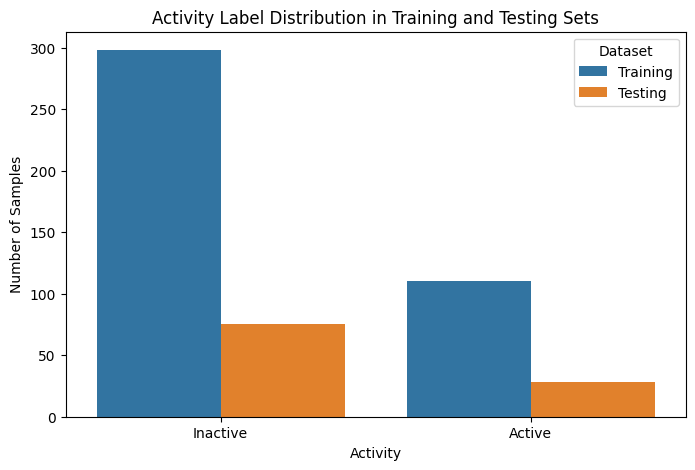

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split


# Count labels in train and test
train_counts = train_df['Activity'].value_counts().sort_index()
test_counts = test_df['Activity'].value_counts().sort_index()


plot_df = pd.DataFrame({
    'Training': train_counts,
    'Testing': test_counts
}).reset_index(names=['Activity_Label'])


plot_df = plot_df.melt(id_vars='Activity_Label', var_name='Dataset', value_name='Count')

# Rename Activity labels for clarity
plot_df['Activity'] = plot_df['Activity_Label'].map({0: 'Inactive', 1: 'Active'})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Activity', y='Count', hue='Dataset', data=plot_df)
plt.title('Activity Label Distribution in Training and Testing Sets')
plt.ylabel('Number of Samples')
plt.xlabel('Activity')
plt.show()

In [6]:
# Save test set CSV to Google Drive folder
val_save_path = '/content/drive/MyDrive/KP/KP imbalance/Test_set.csv'
test_df.to_csv(val_save_path, index=False)
val_save_path = '/content/drive/MyDrive/KP/KP imbalance/Train_set.csv'
train_df.to_csv(val_save_path, index=False)

print(f"Test set saved to: {val_save_path}")
print(f"Training set size: {len(train_df)}") # Corrected variable name for test set size print statement
print(f"Test set size: {len(test_df)}") # Corrected variable name for test set size print statement

Test set saved to: /content/drive/MyDrive/KP/KP imbalance/Train_set.csv
Training set size: 408
Test set size: 103


# Loading training set Calculation feature

In [7]:
import pandas as pd
import numpy as np
train_df = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/Train_set.csv')
print(train_df.head())


                          Sequence  Activity
0         FFPIVAGVAAKVLKKIFCTISKKC         1
1                       AMQNYERRRK         0
2        IARRALKKALRARHTIPQCKKFGRR         1
3    VDKMVPRTFRTVDNLDLPLAEGCPKLGPQ         0
4  SVCVYSQTYDAARWLPERLVRQVSNNNQSRE         0


In [8]:
# Install Biopython if not already installed
!pip install biopython

import pandas as pd
from Bio.SeqUtils import molecular_weight
from Bio.Seq import Seq

# Load the training dataset (update the file path as needed)
file_path = '/content/drive/MyDrive/KP/KP imbalance/Train_set.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Define peptide feature calculation functions

def calculate_charge(sequence):
    """Calculate net charge: K, R, H (+), D, E (-)"""
    positive = sequence.count('K') + sequence.count('R') + sequence.count('H')
    negative = sequence.count('D') + sequence.count('E')
    return positive - negative

def calculate_molecular_weight(sequence):
    """Calculate molecular weight of peptide sequence"""
    return molecular_weight(Seq(sequence), seq_type='protein')

def calculate_hydrophobicity(sequence):
    """Calculate hydrophobicity based on Kyte-Doolittle scale residues"""
    hydrophobic_residues = 'AVILMFWP'
    hydrophobic_score = sum([1 for aa in sequence if aa in hydrophobic_residues])
    return hydrophobic_score

def calculate_number_of_cysteines(sequence):
    """Count cysteine residues"""
    return sequence.count('C')

def calculate_number_of_disulfide_bridges(sequence):
    """Estimate disulfide bridges as integer division of cysteines by 2"""
    cysteines = sequence.count('C')
    return cysteines // 2

def calculate_isoelectric_point(sequence):
    """Simplified isoelectric point estimate"""
    pKa_acidic = {'D': 3.9, 'E': 4.25}
    pKa_basic = {'K': 10.5, 'R': 12.5, 'H': 6.0}
    acidic_count = sum([sequence.count(aa) for aa in pKa_acidic])
    basic_count = sum([sequence.count(aa) for aa in pKa_basic])
    if acidic_count + basic_count > 0:
        pI = (sum([pKa_acidic[aa] * sequence.count(aa) for aa in pKa_acidic]) +
              sum([pKa_basic[aa] * sequence.count(aa) for aa in pKa_basic])) / (acidic_count + basic_count)
    else:
        pI = 7.0  # Neutral default if no acidic/basic residues
    return pI

def amino_acid_composition(sequence):
    """Calculate percentage composition of each amino acid"""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    composition = {aa: sequence.count(aa) for aa in amino_acids}
    total_residues = len(sequence)
    composition_percent = {aa: (count / total_residues) * 100 if total_residues > 0 else 0
                          for aa, count in composition.items()}
    return composition_percent

def secondary_structure_features(sequence):
    """Simplified secondary structure feature counts"""
    helix_aa = 'ALIVMFYW'
    sheet_aa = 'FYW'
    turn_aa = 'GP'
    helix = sum([sequence.count(aa) for aa in helix_aa])
    sheet = sum([sequence.count(aa) for aa in sheet_aa])
    turn = sum([sequence.count(aa) for aa in turn_aa])
    flexibility = helix / len(sequence) if len(sequence) > 0 else 0
    return helix, turn, sheet, flexibility

# Specify the sequence column name in your dataframe
seq_col = 'Sequence'  # Change if your CSV uses a different column name

# Apply feature calculations
data['Length'] = data[seq_col].apply(len)
data['Charge'] = data[seq_col].apply(calculate_charge)
data['Hydrophobicity'] = data[seq_col].apply(calculate_hydrophobicity)
data['Molecular_Weight'] = data[seq_col].apply(calculate_molecular_weight)
data['Number_of_Cysteines'] = data[seq_col].apply(calculate_number_of_cysteines)
data['Number_of_Disulfide_Bridges'] = data[seq_col].apply(calculate_number_of_disulfide_bridges)
data['Isoelectric_Point'] = data[seq_col].apply(calculate_isoelectric_point)
data['Amino_Acid_Composition'] = data[seq_col].apply(amino_acid_composition)
data[['Helix', 'Turn', 'Sheet', 'Flexibility']] = data[seq_col].apply(secondary_structure_features).apply(pd.Series)

# Expand Amino Acid Composition dict into individual columns
aa_columns = pd.DataFrame(data['Amino_Acid_Composition'].tolist(), columns=list('ACDEFGHIKLMNPQRSTVWY'))
data = pd.concat([data, aa_columns], axis=1).drop(columns=['Amino_Acid_Composition'])

# Save the enhanced dataset with features
output_file = '/content/drive/MyDrive/KP/KP imbalance/training_Feature_.csv'
data.to_csv(output_file, index=False)

print(f"Feature calculation complete. Data saved to: {output_file}")
print(data.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.8 MB/s eta 0:00:00
Feature calculation complete. Data saved to: /content/drive/MyDrive/KP/KP imbalance/training_Feature_.csv
                          Sequence  Activity  Length  Charge  Hydrophobicity  \
0         FFPIVAGVAAKVLKKIFCTISKKC         1      24       5              14   
1                       AMQNYERRRK         0      10       3               2   
2        IARRALKKALRARHTIPQCKKFGRR         1      25      11              10   
3    VDKMVPRTFRTVDNLDLPLAEGCPKLGPQ         0      29       0              14   
4  SVCVYSQTYDAARWLPERLVRQVSNNNQSRE         0      31       1              10   

   Molecular_Weight  Number_of_Cysteines  Number_of_Disulfide_Bridges  \
0         2612.2888                    2                            1   
1         1351.5376                    0                            0   
2         2975.6163                    1                            0   
3         3210.7245                    1    

In [9]:
import pandas as pd

# Separate features and label
X_train = data.drop(columns=['Sequence', 'Activity'])  # Features only
y_train = data['Activity']                             # Labels only

# Save features and labels separately to CSV files
X_train.to_csv('/content/drive/MyDrive/KP/KP imbalance/X_train.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/KP/KP imbalance/y_train.csv', index=False)

print("X_train and y_train saved successfully!")


X_train and y_train saved successfully!


# Building model

Step 1: Load training data

In [10]:
import pandas as pd

X_train = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/KP/KP imbalance/y_train.csv').squeeze()


Step 2: Train and evaluate tree-based models (using cross-validation for example)

Evaluating Random Forest...
Random Forest - Mean F1 Score: 0.9013 (+/- 0.0546)
Random Forest - ROC AUC: 1.0000
Random Forest - PR AUC: 1.0000
Random Forest - Sensitivity: 1.0000
Random Forest - Specificity: 1.0000
Random Forest - MCC: 1.0000
Evaluating Gradient Boosting...
Gradient Boosting - Mean F1 Score: 0.8905 (+/- 0.0432)
Gradient Boosting - ROC AUC: 1.0000
Gradient Boosting - PR AUC: 1.0000
Gradient Boosting - Sensitivity: 1.0000
Gradient Boosting - Specificity: 1.0000
Gradient Boosting - MCC: 1.0000
Evaluating XGBoost...
XGBoost - Mean F1 Score: 0.8904 (+/- 0.0521)
XGBoost - ROC AUC: 1.0000
XGBoost - PR AUC: 1.0000
XGBoost - Sensitivity: 1.0000
XGBoost - Specificity: 1.0000
XGBoost - MCC: 1.0000
Evaluating AdaBoost...
AdaBoost - Mean F1 Score: 0.9060 (+/- 0.0512)
AdaBoost - ROC AUC: 1.0000
AdaBoost - PR AUC: 1.0000
AdaBoost - Sensitivity: 1.0000
AdaBoost - Specificity: 1.0000
AdaBoost - MCC: 1.0000
Evaluating SVM...
SVM - Mean F1 Score: 0.0000 (+/- 0.0000)
SVM - ROC AUC: 0.9619


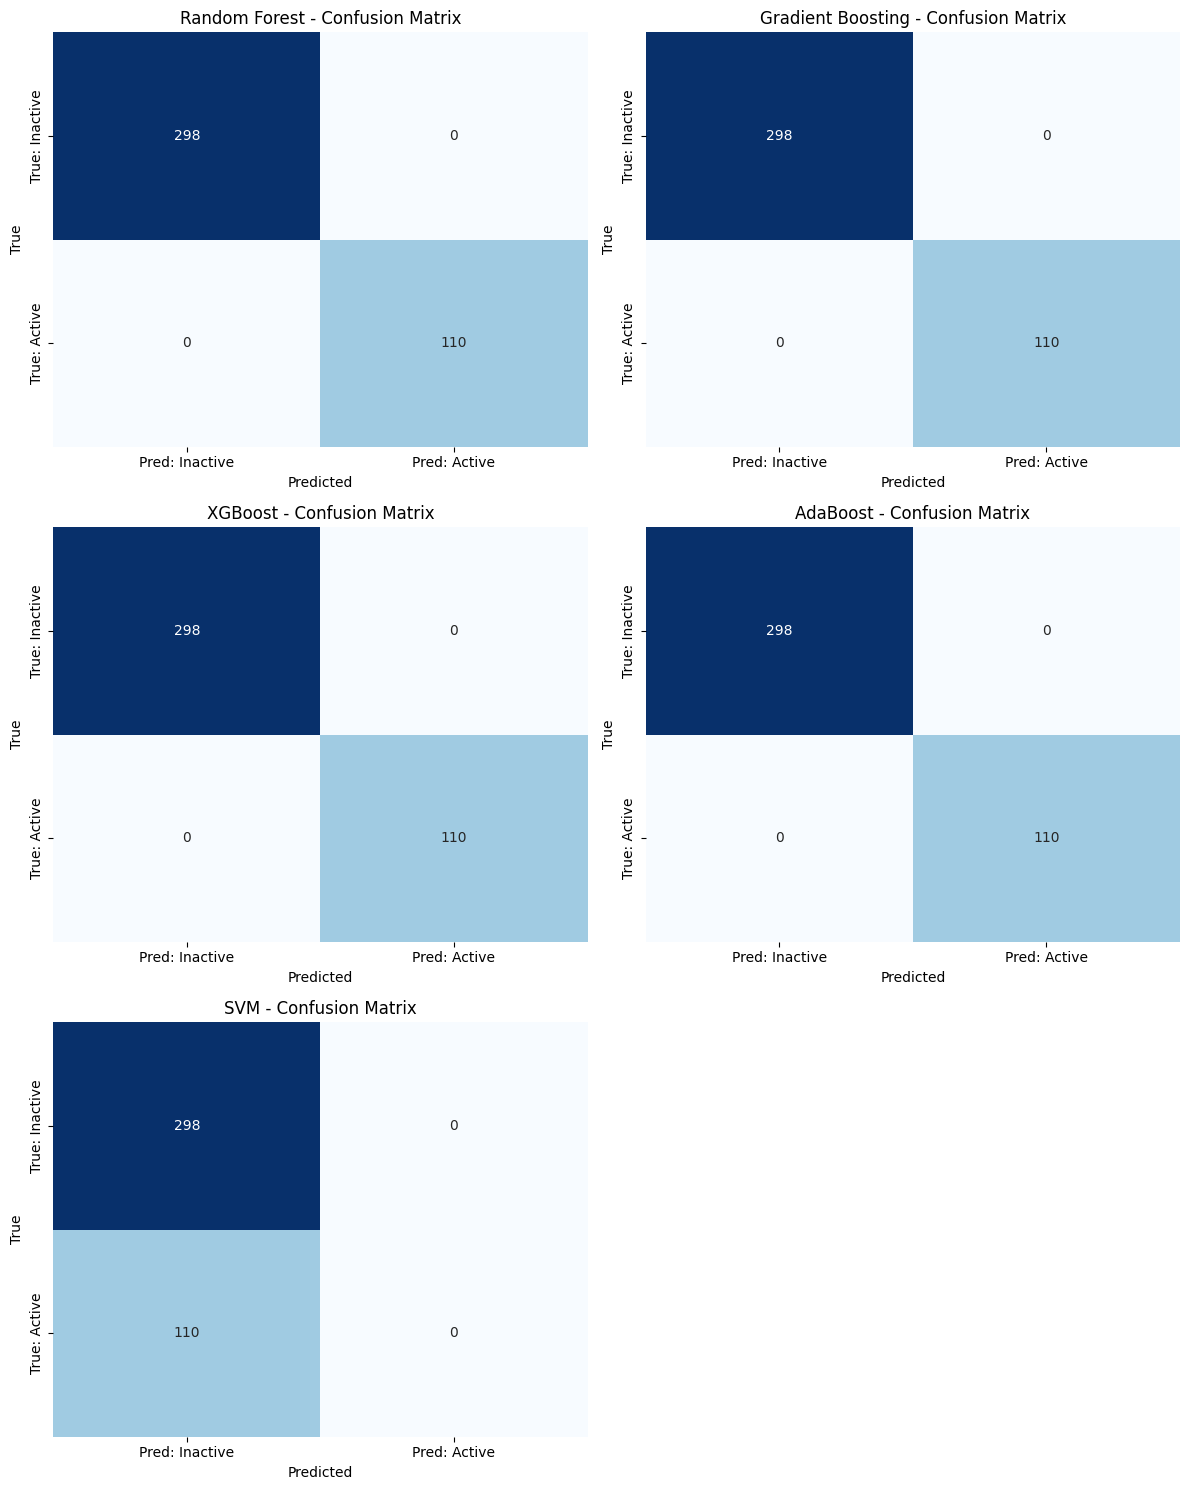


Model Comparison Summary:

F1 Scores:
Random Forest: 0.9013 (+/- 0.0546)
Gradient Boosting: 0.8905 (+/- 0.0432)
XGBoost: 0.8904 (+/- 0.0521)
AdaBoost: 0.9060 (+/- 0.0512)
SVM: 0.0000 (+/- 0.0000)

ROC AUC Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.9619

PR AUC Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.9267

Sensitivity (Recall) Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.0000

Specificity Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 1.0000

MCC Scores:
Random Forest: 1.0000
Gradient Boosting: 1.0000
XGBoost: 1.0000
AdaBoost: 1.0000
SVM: 0.0000


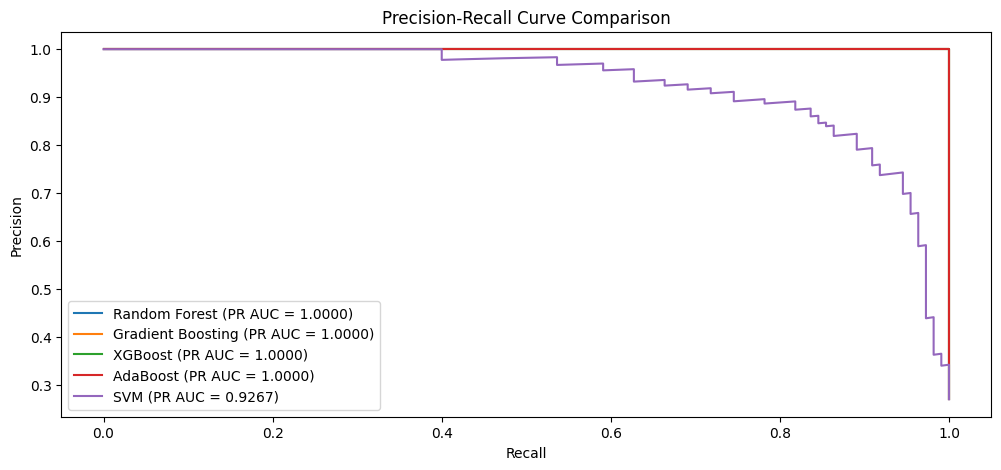

In [37]:
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    recall_score
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier # Import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
from xgboost import XGBClassifier # Import XGBClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd # Ensure pandas is imported if not already available

# Define the models you want to evaluate
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),  # Adding SVM

}

# Prepare lists to store results
f1_scores = []
roc_aucs = []
pr_aucs = []
sensitivities = []
specificities = []
mcc_scores = []


n_rows = (len(models) + 1) // 2 # Integer division rounds down, add 1 before division to round up if needed
n_cols = 2
plt.figure(figsize=(12, n_rows * 5)) # Adjust figure height based on number of rows

# Train, evaluate and collect metrics for each model
for i, (name, model) in enumerate(models.items(), 1):
    print(f"Evaluating {name}...")

    # Cross-validation: F1 score
    f1_cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    mean_f1 = np.mean(f1_cv_scores)
    std_f1 = np.std(f1_cv_scores)

    # Train the model on the entire training set for later evaluation
    model.fit(X_train, y_train)

    # ROC AUC Score
    y_prob = model.predict_proba(X_train)[:, 1]  # Probability for positive class
    roc_auc = roc_auc_score(y_train, y_prob)

    # PR AUC Score
    pr_auc = average_precision_score(y_train, y_prob)

    # Store results for comparison
    f1_scores.append((name, mean_f1, std_f1))
    roc_aucs.append((name, roc_auc))
    pr_aucs.append((name, pr_auc))

    # Confusion Matrix
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate Sensitivity, Specificity, and MCC
    sensitivity = recall_score(y_train, y_pred)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate
    mcc = matthews_corrcoef(y_train, y_pred)

    # Store additional metrics
    sensitivities.append((name, sensitivity))
    specificities.append((name, specificity))
    mcc_scores.append((name, mcc))

    # Display metrics
    print(f"{name} - Mean F1 Score: {mean_f1:.4f} (+/- {std_f1:.4f})")
    print(f"{name} - ROC AUC: {roc_auc:.4f}")
    print(f"{name} - PR AUC: {pr_auc:.4f}")
    print(f"{name} - Sensitivity: {sensitivity:.4f}")
    print(f"{name} - Specificity: {specificity:.4f}")
    print(f"{name} - MCC: {mcc:.4f}")

    # Plot confusion matrix
    # Changed subplot grid to n_rows x n_cols to accommodate all models
    plt.subplot(n_rows, n_cols, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Inactive', 'Pred: Active'],
                yticklabels=['True: Inactive', 'True: Active'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')

plt.tight_layout()
plt.show()

# Summary of model comparison
print("\nModel Comparison Summary:")

# F1 Scores
print("\nF1 Scores:")
for model_name, f1, std in f1_scores:
    print(f"{model_name}: {f1:.4f} (+/- {std:.4f})")

# ROC AUC Scores
print("\nROC AUC Scores:")
for model_name, auc in roc_aucs:
    print(f"{model_name}: {auc:.4f}")

# PR AUC Scores
print("\nPR AUC Scores:")
for model_name, auc in pr_aucs:
    print(f"{model_name}: {auc:.4f}")

# Sensitivity
print("\nSensitivity (Recall) Scores:")
for model_name, sensitivity in sensitivities:
    print(f"{model_name}: {sensitivity:.4f}")

# Specificity
print("\nSpecificity Scores:")
for model_name, specificity in specificities:
    print(f"{model_name}: {specificity:.4f}")

# MCC Scores
print("\nMCC Scores:")
for model_name, mcc in mcc_scores:
    print(f"{model_name}: {mcc:.4f}")

# Optional: If you want to visualize PR curves for all models

plt.figure(figsize=(12, 5))
for i, (name, model) in enumerate(models.items(), 1):
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])
    plt.plot(recall, precision, label=f'{name} (PR AUC = {pr_aucs[i-1][1]:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.show()

Replicate running 3 time

In [38]:
from sklearn.model_selection import train_test_split
import pandas as pd

if 'Sequence' in data.columns:
    X = data.drop(columns=['Activity', 'Sequence'])
else:
    X = data.drop(columns=['Activity'])

y = data['Activity']


# Store average metrics across 3 runs
results_over_runs = {
    'F1': [],
    'ROC AUC': [],
    'PR AUC': [],
    'Sensitivity': [],
    'Specificity': [],
    'MCC': []
}

for run in range(1, 4):
    print(f"\n========== Run {run} ==========")

    # Split the data randomly each run using the full dataset X and y
    X_train_run, X_test_run, y_train_run, y_test_run = train_test_split(X, y, test_size=0.2, stratify=y, random_state=None)

    f1_scores = []
    roc_aucs = []
    pr_aucs = []
    sensitivities = []
    specificities = []
    mcc_scores = []

    # Note: You are using the same 'models' dictionary defined in the previous cell.
    # This should be fine as long as that cell was executed.

    for name, model in models.items():
        print(f"\nEvaluating {name}...")

        # Cross-validation: F1 score using the current run's training data
        f1_cv_scores = cross_val_score(model, X_train_run, y_train_run, cv=5, scoring='f1')
        mean_f1 = np.mean(f1_cv_scores)
        std_f1 = np.std(f1_cv_scores)

        # Train the model on the entire training set for the current run
        model.fit(X_train_run, y_train_run)

        # Evaluate on the current run's training set (or test set - evaluation is confusing here)
        # The original code evaluates on X_train/y_train which changes each run.
        # It seems you want to evaluate on the test set for this run.
        # Let's evaluate on X_test_run/y_test_run.
        y_prob = model.predict_proba(X_test_run)[:, 1]  # Probability for positive class on test set
        y_pred = model.predict(X_test_run)             # Predictions on test set

        roc_auc = roc_auc_score(y_test_run, y_prob)
        pr_auc = average_precision_score(y_test_run, y_prob)

        cm = confusion_matrix(y_test_run, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = recall_score(y_test_run, y_pred)
        # Handle potential division by zero if tn + fp is zero
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        mcc = matthews_corrcoef(y_test_run, y_pred)

        f1 = f1_score(y_test_run, y_pred) # Calculate F1 on the test set for this run

        f1_scores.append((name, f1)) # Store test set F1
        roc_aucs.append((name, roc_auc))
        pr_aucs.append((name, pr_auc))
        sensitivities.append((name, sensitivity))
        specificities.append((name, specificity))
        mcc_scores.append((name, mcc))

        # Print cross-validation F1 and test set metrics
        print(f"{name} - CV F1: {mean_f1:.4f} (+/- {std_f1:.4f}) | Test F1: {f1:.4f} | Test ROC AUC: {roc_auc:.4f} | Test PR AUC: {pr_auc:.4f}")
        print(f"{name} - Test Sensitivity: {sensitivity:.4f} | Test Specificity: {specificity:.4f} | Test MCC: {mcc:.4f}")

    # Store results from this run
    # Note: You are storing lists of tuples, which means the 'average' will be based on the tuple itself.
    # It's better to store dictionaries indexed by model name for easier averaging later.
    run_f1_dict = {name: f1 for name, f1 in f1_scores}
    run_roc_auc_dict = {name: auc for name, auc in roc_aucs}
    run_pr_auc_dict = {name: auc for name, auc in pr_aucs}
    run_sensitivity_dict = {name: sens for name, sens in sensitivities}
    run_specificity_dict = {name: spec for name, spec in specificities}
    run_mcc_dict = {name: mcc for name, mcc in mcc_scores}

    results_over_runs['F1'].append(run_f1_dict)
    results_over_runs['ROC AUC'].append(run_roc_auc_dict)
    results_over_runs['PR AUC'].append(run_pr_auc_dict)
    results_over_runs['Sensitivity'].append(run_sensitivity_dict)
    results_over_runs['Specificity'].append(run_specificity_dict)
    results_over_runs['MCC'].append(run_mcc_dict)


# After the loop, you can process results_over_runs to calculate average metrics
print("\n========== Average Metrics Over Runs ==========")

average_results = {metric: {} for metric in results_over_runs.keys()}

for metric_name in results_over_runs.keys():
    for model_name in models.keys():
        # Collect all scores for this model and metric across runs
        scores = [run_results[model_name] for run_results in results_over_runs[metric_name]]
        average_results[metric_name][model_name] = np.mean(scores)

# Print average results
for metric_name, model_scores in average_results.items():
    print(f"\n{metric_name}:")
    for model_name, avg_score in model_scores.items():
        print(f"{model_name}: {avg_score:.4f}")


========== Run 1 ==========

Evaluating Random Forest...
Random Forest - CV F1: 0.9031 (+/- 0.0613) | Test F1: 0.8837 | Test ROC AUC: 0.9648 | Test PR AUC: 0.9299
Random Forest - Test Sensitivity: 0.8636 | Test Specificity: 0.9667 | Test MCC: 0.8428

Evaluating Gradient Boosting...
Gradient Boosting - CV F1: 0.8883 (+/- 0.0476) | Test F1: 0.8636 | Test ROC AUC: 0.9348 | Test PR AUC: 0.9236
Gradient Boosting - Test Sensitivity: 0.8636 | Test Specificity: 0.9500 | Test MCC: 0.8136

Evaluating XGBoost...
XGBoost - CV F1: 0.9245 (+/- 0.0317) | Test F1: 0.8444 | Test ROC AUC: 0.9402 | Test PR AUC: 0.8560
XGBoost - Test Sensitivity: 0.8636 | Test Specificity: 0.9333 | Test MCC: 0.7860

Evaluating AdaBoost...
AdaBoost - CV F1: 0.8773 (+/- 0.0278) | Test F1: 0.8837 | Test ROC AUC: 0.9265 | Test PR AUC: 0.9170
AdaBoost - Test Sensitivity: 0.8636 | Test Specificity: 0.9667 | Test MCC: 0.8428

Evaluating SVM...
SVM - CV F1: 0.0000 (+/- 0.0000) | Test F1: 0.0000 | Test ROC AUC: 0.8674 | Test PR A

comprae machine learning

Download focus on 3 model with good performances

In [39]:
import joblib

# Select the three best models based on F1 Scores (you can adjust based on any other metric)
best_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and save these models
for name, model in best_models.items():
    print(f"Training {name}...")

    # Train the model on the entire training data
    model.fit(X_train, y_train)

    # Save the trained model to a file
    model_filename = f"/content/drive/MyDrive/KP/KP imbalance/{name}_model.pkl"
    joblib.dump(model, model_filename)

    print(f"{name} model saved to: {model_filename}")


Training Random Forest...
Random Forest model saved to: /content/drive/MyDrive/KP/KP imbalance/Random Forest_model.pkl
Training AdaBoost...
AdaBoost model saved to: /content/drive/MyDrive/KP/KP imbalance/AdaBoost_model.pkl
Training Gradient Boosting...
Gradient Boosting model saved to: /content/drive/MyDrive/KP/KP imbalance/Gradient Boosting_model.pkl


# Load and Evaluate on Test Set

In [40]:
# Load the saved models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random Forest_model.pkl')
ab_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient Boosting_model.pkl')


In [41]:
# Load the test data (update with your actual file path)
test_file_path = '//content/drive/MyDrive/KP/KP imbalance/Test_set.csv'  # Replace with your actual test file path
test_data = pd.read_csv(test_file_path, encoding='ISO-8859-1')

# Assuming the 'Sequence' column is the one containing the peptide sequences in the test data
test_data['Length'] = test_data['Sequence'].apply(len)
test_data['Charge'] = test_data['Sequence'].apply(calculate_charge)
test_data['Hydrophobicity'] = test_data['Sequence'].apply(calculate_hydrophobicity)
test_data['Molecular_Weight'] = test_data['Sequence'].apply(calculate_molecular_weight)
test_data['Number_of_Cysteines'] = test_data['Sequence'].apply(calculate_number_of_cysteines)
test_data['Number_of_Disulfide_Bridges'] = test_data['Sequence'].apply(calculate_number_of_disulfide_bridges)
test_data['Isoelectric_Point'] = test_data['Sequence'].apply(calculate_isoelectric_point)
test_data['Amino_Acid_Composition'] = test_data['Sequence'].apply(amino_acid_composition)
test_data[['Helix', 'Turn', 'Sheet', 'Flexibility']] = test_data['Sequence'].apply(secondary_structure_features).apply(pd.Series)

# Expand Amino Acid Composition dictionary into separate columns
aa_columns = pd.DataFrame(test_data['Amino_Acid_Composition'].tolist(), columns=list('ACDEFGHIKLMNPQRSTVWY'))
test_data = pd.concat([test_data, aa_columns], axis=1).drop(columns=['Amino_Acid_Composition'])

# Now, X_test should contain all the feature columns (excluding the target column 'Activity')
X_test = test_data.drop(columns=['Activity', 'Sequence'])

# Optionally, if you need y_test (labels)
y_test = test_data['Activity']


# Save X_test and y_test to CSV files for later use
X_test_file = '/content/drive/MyDrive/KP/KP imbalance/X_test.csv'
y_test_file = '/content/drive/MyDrive/KP/KP imbalance/y_test.csv'

X_test.to_csv(X_test_file, index=False)
y_test.to_csv(y_test_file, index=False)

# Confirming that the files are saved
print(f"X_test saved to: {X_test_file}")
print(f"y_test saved to: {y_test_file}")

X_test saved to: /content/drive/MyDrive/KP/KP imbalance/X_test.csv
y_test saved to: /content/drive/MyDrive/KP/KP imbalance/y_test.csv


In [42]:
print(X_test.head())  # Show the first few rows of X_test
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


   Length  Charge  Hydrophobicity  Molecular_Weight  Number_of_Cysteines  \
0      29       3              13         3216.7058                    0   
1      40      -3              15         4234.6341                    2   
2      45      -8              22         5523.9594                    0   
3      36       9              18         4390.3795                    2   
4      27       6              16         3095.7296                    0   

   Number_of_Disulfide_Bridges  Isoelectric_Point  Helix  Turn  Sheet  ...  \
0                            0           8.950000   12.0   5.0    4.0  ...   
1                            1           6.507143   16.0   5.0    3.0  ...   
2                            0           4.939286   18.0   8.0   10.0  ...   
3                            1          10.888889   18.0   2.0    6.0  ...   
4                            0          11.500000   15.0   3.0    3.0  ...   

          M         N          P         Q          R          S         T

The result for predict test set

Evaluating Random Forest...
Random Forest - F1 Score: 0.8571
Random Forest - ROC AUC: 0.9936
Random Forest - PR AUC: 0.9821
Random Forest - Sensitivity: 0.7500
Random Forest - Specificity: 1.0000
Random Forest - MCC: 0.8282
Evaluating AdaBoost...
AdaBoost - F1 Score: 0.8462
AdaBoost - ROC AUC: 0.9914
AdaBoost - PR AUC: 0.9769
AdaBoost - Sensitivity: 0.7857
AdaBoost - Specificity: 0.9733
AdaBoost - MCC: 0.7988
Evaluating Gradient Boosting...
Gradient Boosting - F1 Score: 0.9091
Gradient Boosting - ROC AUC: 0.9895
Gradient Boosting - PR AUC: 0.9756
Gradient Boosting - Sensitivity: 0.8929
Gradient Boosting - Specificity: 0.9733
Gradient Boosting - MCC: 0.8763


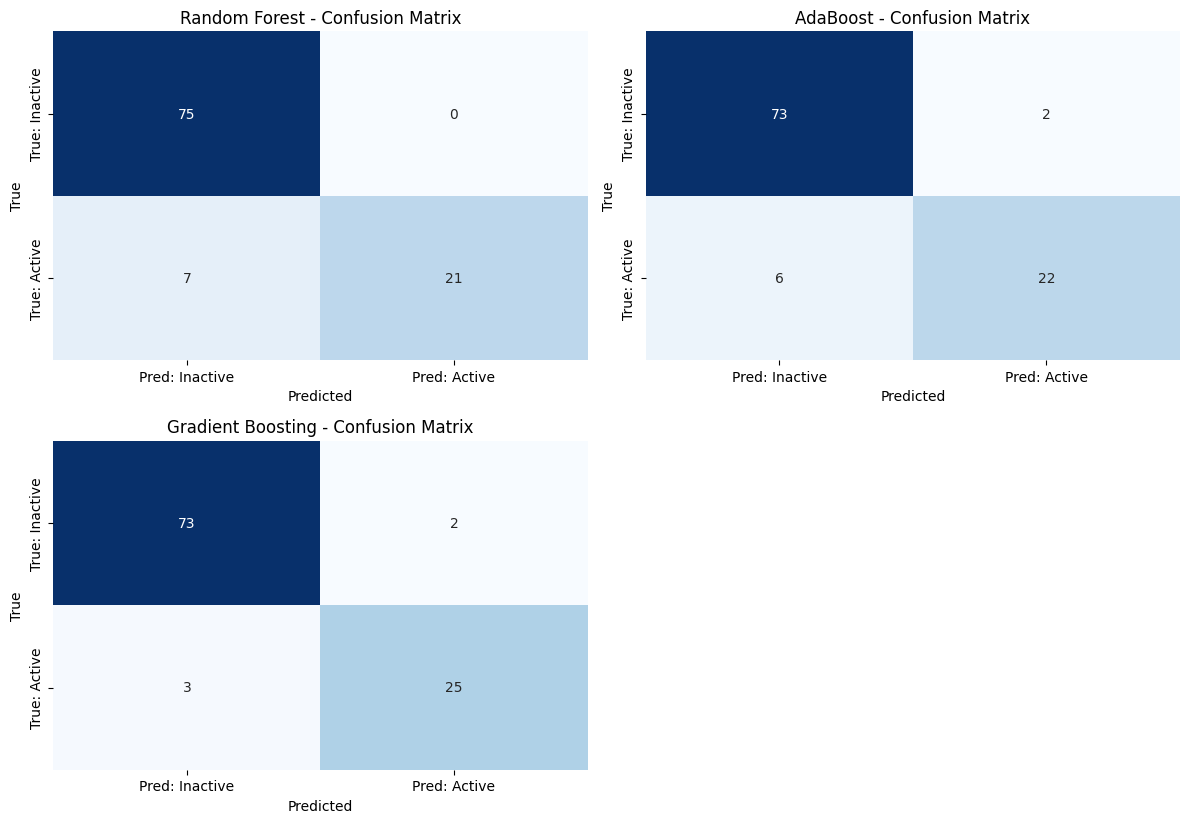


Model Comparison Summary:

F1 Scores:
Random Forest: 0.8571
AdaBoost: 0.8462
Gradient Boosting: 0.9091

ROC AUC Scores:
Random Forest: 0.9936
AdaBoost: 0.9914
Gradient Boosting: 0.9895

PR AUC Scores:
Random Forest: 0.9821
AdaBoost: 0.9769
Gradient Boosting: 0.9756

Sensitivity (Recall) Scores:
Random Forest: 0.7500
AdaBoost: 0.7857
Gradient Boosting: 0.8929

Specificity Scores:
Random Forest: 1.0000
AdaBoost: 0.9733
Gradient Boosting: 0.9733

MCC Scores:
Random Forest: 0.8282
AdaBoost: 0.7988
Gradient Boosting: 0.8763


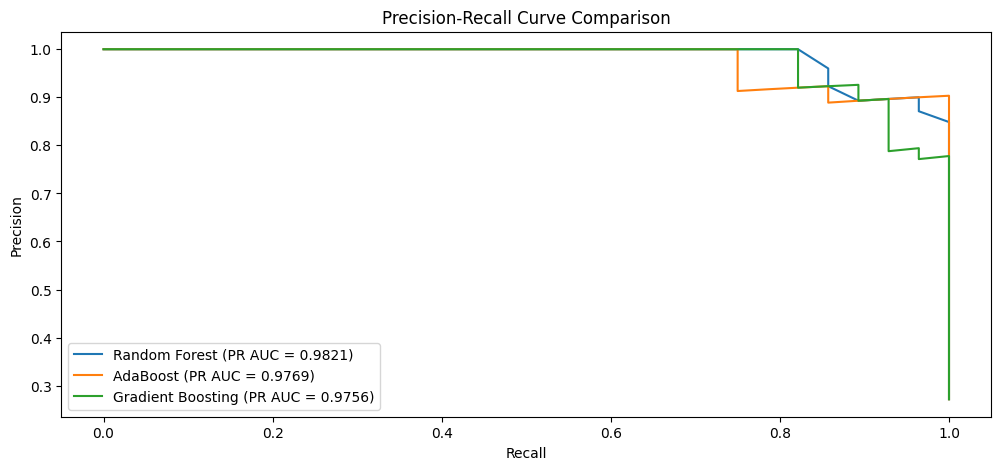

In [43]:
import joblib
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random Forest_model.pkl')
ab_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient Boosting_model.pkl')

# List of models to evaluate
models = {
    'Random Forest': rf_model,
    'AdaBoost': ab_model,
    'Gradient Boosting': gb_model
}

# Prepare lists to store results
f1_scores = []
roc_aucs = []
pr_aucs = []
sensitivities = []
specificities = []
mcc_scores = []

# Plot the confusion matrices in a publication style
plt.figure(figsize=(12, 12))

# Evaluate and collect metrics for each model
for i, (name, model) in enumerate(models.items(), 1):
    print(f"Evaluating {name}...")

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability for positive class

    # F1 Score
    f1 = f1_score(y_test, y_pred)

    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_prob)

    # PR AUC Score
    pr_auc = average_precision_score(y_test, y_prob)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Sensitivity (Recall)
    sensitivity = recall_score(y_test, y_pred)

    # Specificity
    specificity = tn / (tn + fp)

    # MCC
    mcc = matthews_corrcoef(y_test, y_pred)

    # Store results for comparison
    f1_scores.append((name, f1))
    roc_aucs.append((name, roc_auc))
    pr_aucs.append((name, pr_auc))
    sensitivities.append((name, sensitivity))
    specificities.append((name, specificity))
    mcc_scores.append((name, mcc))

    # Display metrics
    print(f"{name} - F1 Score: {f1:.4f}")
    print(f"{name} - ROC AUC: {roc_auc:.4f}")
    print(f"{name} - PR AUC: {pr_auc:.4f}")
    print(f"{name} - Sensitivity: {sensitivity:.4f}")
    print(f"{name} - Specificity: {specificity:.4f}")
    print(f"{name} - MCC: {mcc:.4f}")

    # Plot confusion matrix
    plt.subplot(3, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Inactive', 'Pred: Active'],
                yticklabels=['True: Inactive', 'True: Active'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Summary of model comparison
print("\nModel Comparison Summary:")

# F1 Scores
print("\nF1 Scores:")
for model_name, f1 in f1_scores:
    print(f"{model_name}: {f1:.4f}")

# ROC AUC Scores
print("\nROC AUC Scores:")
for model_name, auc in roc_aucs:
    print(f"{model_name}: {auc:.4f}")

# PR AUC Scores
print("\nPR AUC Scores:")
for model_name, auc in pr_aucs:
    print(f"{model_name}: {auc:.4f}")

# Sensitivity
print("\nSensitivity (Recall) Scores:")
for model_name, sensitivity in sensitivities:
    print(f"{model_name}: {sensitivity:.4f}")

# Specificity
print("\nSpecificity Scores:")
for model_name, specificity in specificities:
    print(f"{model_name}: {specificity:.4f}")

# MCC Scores
print("\nMCC Scores:")
for model_name, mcc in mcc_scores:
    print(f"{model_name}: {mcc:.4f}")

# Optional: If you want to visualize PR curves for all models
plt.figure(figsize=(12, 5))
for i, (name, model) in enumerate(models.items(), 1):
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, label=f'{name} (PR AUC = {pr_aucs[i-1][1]:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.show()


3 replicatiob Predict on test set


================ Run 1 ================

Evaluating Random Forest...
Random Forest - Accuracy     : 0.9320
Random Forest - F1 Score     : 0.8571
Random Forest - ROC AUC      : 0.9936
Random Forest - PR AUC       : 0.9821
Random Forest - Sensitivity  : 0.7500
Random Forest - Specificity  : 1.0000
Random Forest - MCC          : 0.8282
Evaluating AdaBoost...
AdaBoost - Accuracy     : 0.9223
AdaBoost - F1 Score     : 0.8462
AdaBoost - ROC AUC      : 0.9914
AdaBoost - PR AUC       : 0.9769
AdaBoost - Sensitivity  : 0.7857
AdaBoost - Specificity  : 0.9733
AdaBoost - MCC          : 0.7988
Evaluating Gradient Boosting...
Gradient Boosting - Accuracy     : 0.9515
Gradient Boosting - F1 Score     : 0.9091
Gradient Boosting - ROC AUC      : 0.9895
Gradient Boosting - PR AUC       : 0.9756
Gradient Boosting - Sensitivity  : 0.8929
Gradient Boosting - Specificity  : 0.9733
Gradient Boosting - MCC          : 0.8763


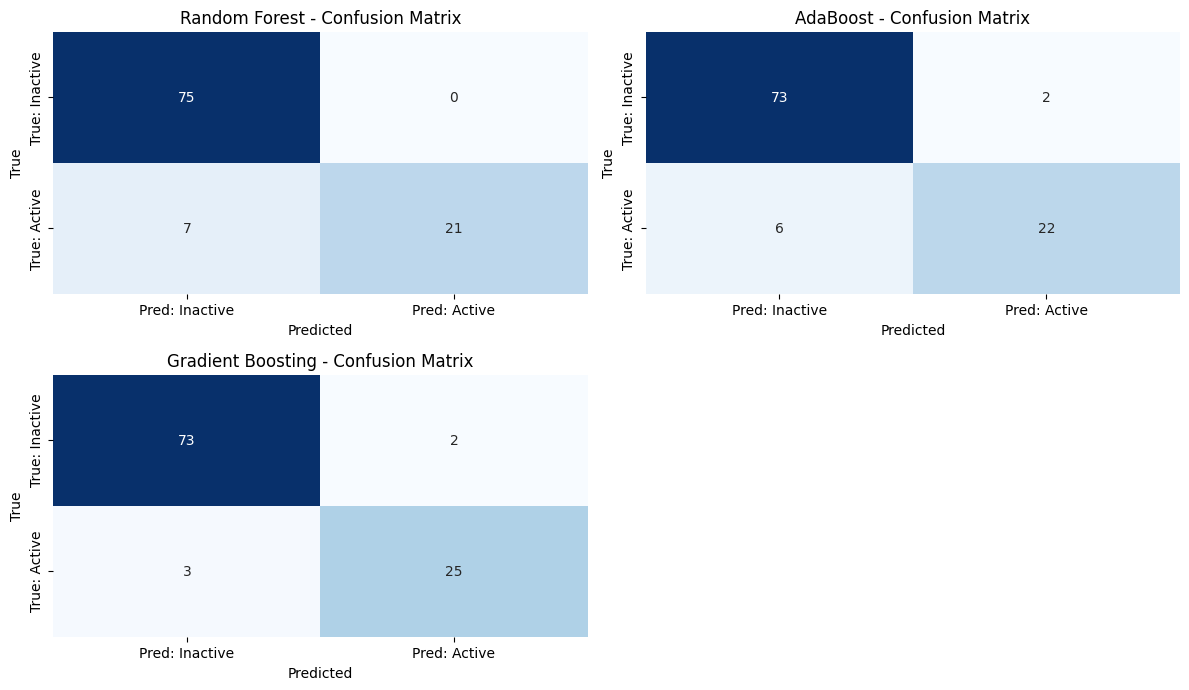


================ Run 2 ================

Evaluating Random Forest...
Random Forest - Accuracy     : 0.9320
Random Forest - F1 Score     : 0.8571
Random Forest - ROC AUC      : 0.9936
Random Forest - PR AUC       : 0.9821
Random Forest - Sensitivity  : 0.7500
Random Forest - Specificity  : 1.0000
Random Forest - MCC          : 0.8282
Evaluating AdaBoost...
AdaBoost - Accuracy     : 0.9223
AdaBoost - F1 Score     : 0.8462
AdaBoost - ROC AUC      : 0.9914
AdaBoost - PR AUC       : 0.9769
AdaBoost - Sensitivity  : 0.7857
AdaBoost - Specificity  : 0.9733
AdaBoost - MCC          : 0.7988
Evaluating Gradient Boosting...
Gradient Boosting - Accuracy     : 0.9515
Gradient Boosting - F1 Score     : 0.9091
Gradient Boosting - ROC AUC      : 0.9895
Gradient Boosting - PR AUC       : 0.9756
Gradient Boosting - Sensitivity  : 0.8929
Gradient Boosting - Specificity  : 0.9733
Gradient Boosting - MCC          : 0.8763


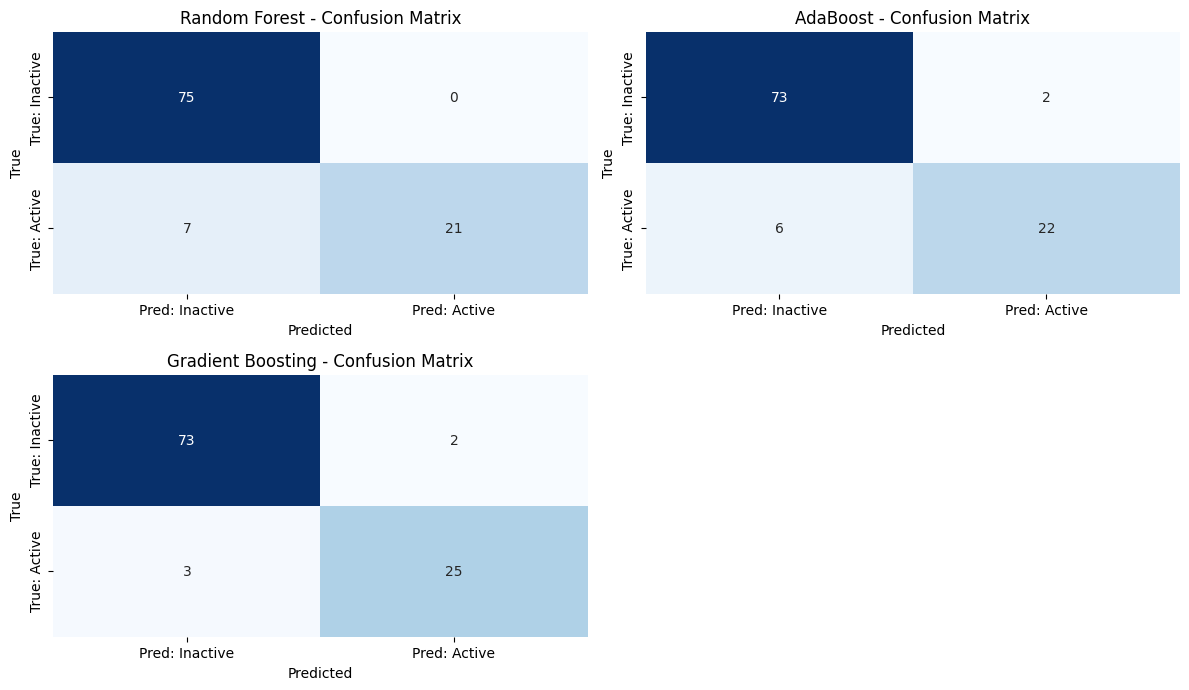


================ Run 3 ================

Evaluating Random Forest...
Random Forest - Accuracy     : 0.9320
Random Forest - F1 Score     : 0.8571
Random Forest - ROC AUC      : 0.9936
Random Forest - PR AUC       : 0.9821
Random Forest - Sensitivity  : 0.7500
Random Forest - Specificity  : 1.0000
Random Forest - MCC          : 0.8282
Evaluating AdaBoost...
AdaBoost - Accuracy     : 0.9223
AdaBoost - F1 Score     : 0.8462
AdaBoost - ROC AUC      : 0.9914
AdaBoost - PR AUC       : 0.9769
AdaBoost - Sensitivity  : 0.7857
AdaBoost - Specificity  : 0.9733
AdaBoost - MCC          : 0.7988
Evaluating Gradient Boosting...
Gradient Boosting - Accuracy     : 0.9515
Gradient Boosting - F1 Score     : 0.9091
Gradient Boosting - ROC AUC      : 0.9895
Gradient Boosting - PR AUC       : 0.9756
Gradient Boosting - Sensitivity  : 0.8929
Gradient Boosting - Specificity  : 0.9733
Gradient Boosting - MCC          : 0.8763


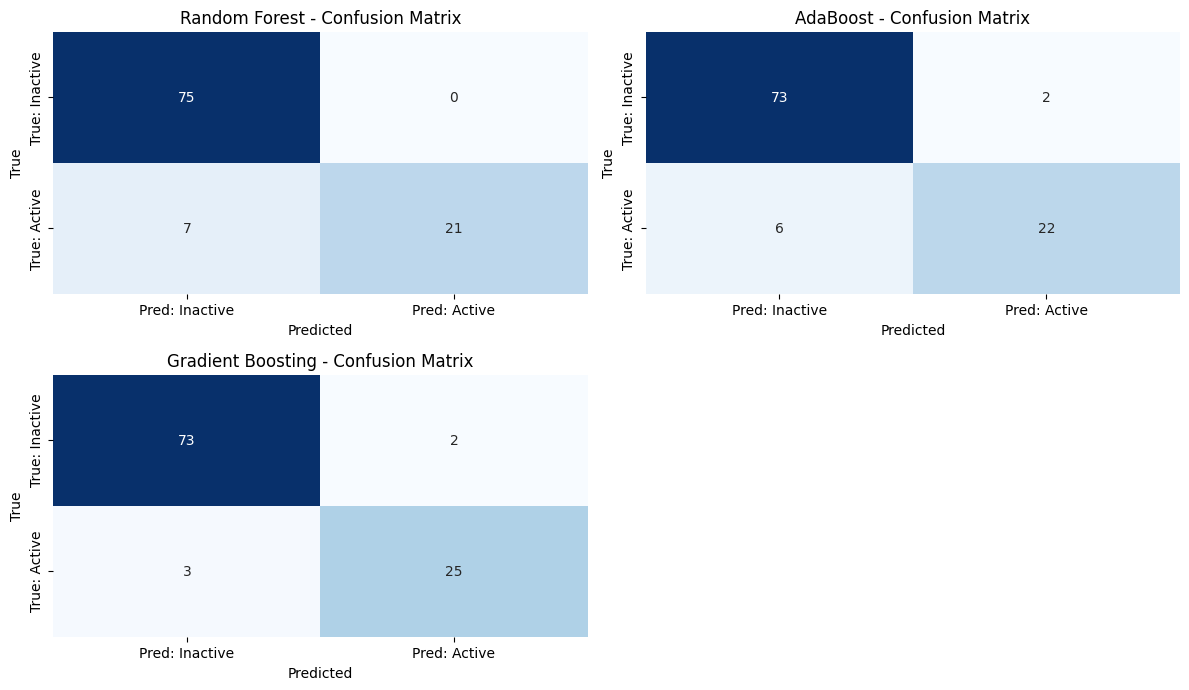


============== AVERAGE METRICS OVER 3 RUNS ==============


Random Forest Average Metrics:
Accuracy      : 0.9320
F1 Score      : 0.8571
ROC AUC       : 0.9936
PR AUC        : 0.9821
Sensitivity   : 0.7500
Specificity   : 1.0000
MCC           : 0.8282

AdaBoost Average Metrics:
Accuracy      : 0.9223
F1 Score      : 0.8462
ROC AUC       : 0.9914
PR AUC        : 0.9769
Sensitivity   : 0.7857
Specificity   : 0.9733
MCC           : 0.7988

Gradient Boosting Average Metrics:
Accuracy      : 0.9515
F1 Score      : 0.9091
ROC AUC       : 0.9895
PR AUC        : 0.9756
Sensitivity   : 0.8929
Specificity   : 0.9733
MCC           : 0.8763


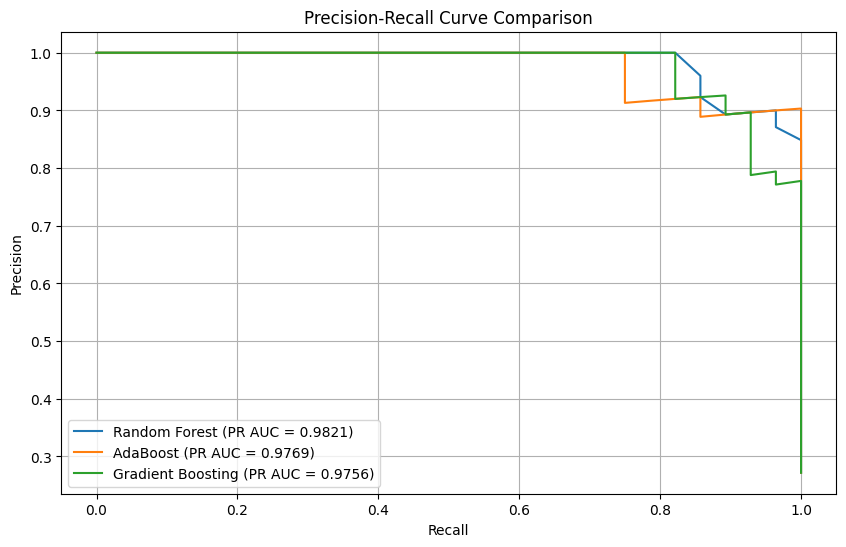

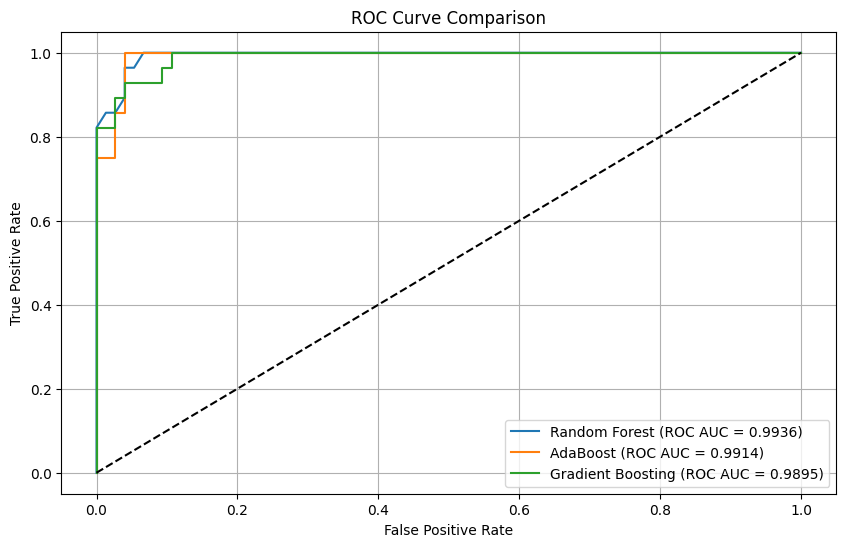

In [45]:
import joblib
import numpy as np
from sklearn.metrics import (
    confusion_matrix, matthews_corrcoef, roc_auc_score, average_precision_score,
    precision_recall_curve, recall_score, f1_score, roc_curve, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random Forest_model.pkl')
ab_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient Boosting_model.pkl')

models = {
    'Random Forest': rf_model,
    'AdaBoost': ab_model,
    'Gradient Boosting': gb_model
}

# To store results for each run
all_metrics = defaultdict(list)

# Run 3 evaluations
for run in range(3):
    print(f"\n================ Run {run+1} ================\n")
    plt.figure(figsize=(12, 10))

    for i, (name, model) in enumerate(models.items(), 1):
        print(f"Evaluating {name}...")

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        sensitivity = recall_score(y_test, y_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        mcc = matthews_corrcoef(y_test, y_pred)

        # Store metrics
        all_metrics[f"{name}_f1"].append(f1)
        all_metrics[f"{name}_accuracy"].append(accuracy)
        all_metrics[f"{name}_roc_auc"].append(roc_auc)
        all_metrics[f"{name}_pr_auc"].append(pr_auc)
        all_metrics[f"{name}_sensitivity"].append(sensitivity)
        all_metrics[f"{name}_specificity"].append(specificity)
        all_metrics[f"{name}_mcc"].append(mcc)

        print(f"{name} - Accuracy     : {accuracy:.4f}")
        print(f"{name} - F1 Score     : {f1:.4f}")
        print(f"{name} - ROC AUC      : {roc_auc:.4f}")
        print(f"{name} - PR AUC       : {pr_auc:.4f}")
        print(f"{name} - Sensitivity  : {sensitivity:.4f}")
        print(f"{name} - Specificity  : {specificity:.4f}")
        print(f"{name} - MCC          : {mcc:.4f}")

        # Plot Confusion Matrix
        plt.subplot(3, 2, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Pred: Inactive', 'Pred: Active'],
                    yticklabels=['True: Inactive', 'True: Active'])
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('True')

    plt.tight_layout()
    plt.show()

# ==== Average Metrics over 3 Runs ====
print("\n============== AVERAGE METRICS OVER 3 RUNS ==============\n")
for name in models.keys():
    print(f"\n{name} Average Metrics:")
    print(f"Accuracy      : {np.mean(all_metrics[f'{name}_accuracy']):.4f}")
    print(f"F1 Score      : {np.mean(all_metrics[f'{name}_f1']):.4f}")
    print(f"ROC AUC       : {np.mean(all_metrics[f'{name}_roc_auc']):.4f}")
    print(f"PR AUC        : {np.mean(all_metrics[f'{name}_pr_auc']):.4f}")
    print(f"Sensitivity   : {np.mean(all_metrics[f'{name}_sensitivity']):.4f}")
    print(f"Specificity   : {np.mean(all_metrics[f'{name}_specificity']):.4f}")
    print(f"MCC           : {np.mean(all_metrics[f'{name}_mcc']):.4f}")

# ==== PR CURVES ====
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (PR AUC = {pr_auc:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# ==== ROC CURVES ====
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (ROC AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [30]:
!pip install lime


Explaining using Random Forest...



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted Probabilities for Model RandomForestClassifier:
Inactive: 0.1300, Active: 0.8700


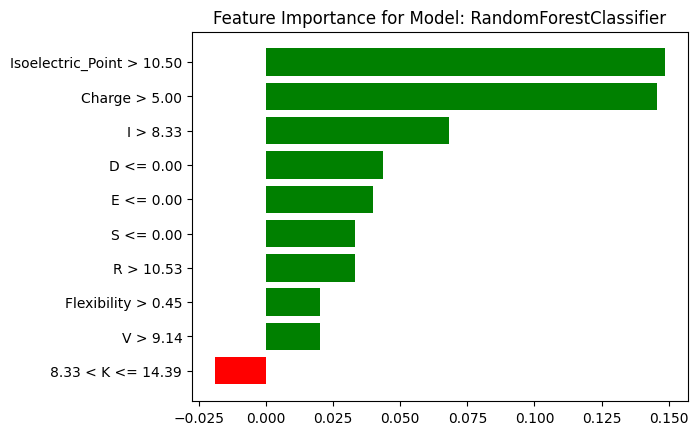

Explaining using Gradient Boosting...

Predicted Probabilities for Model GradientBoostingClassifier:
Inactive: 0.0053, Active: 0.9947


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


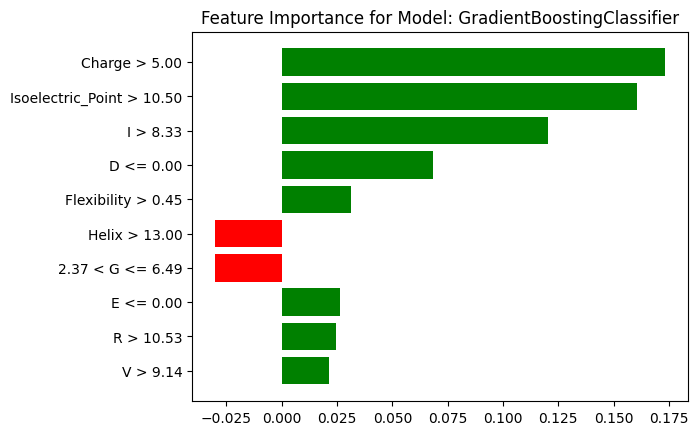

Explaining using AdaBoost...



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Predicted Probabilities for Model AdaBoostClassifier:
Inactive: 0.4054, Active: 0.5946


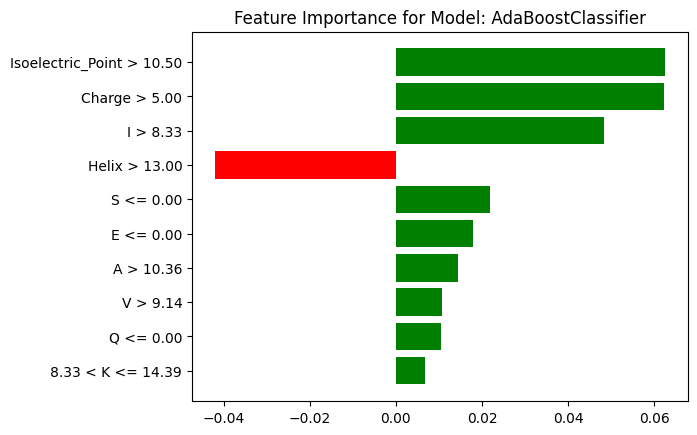

In [46]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import joblib

# Load your trained models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random Forest_model.pkl')
ab_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient Boosting_model.pkl')

# Set up the LIME explainer using the original unscaled data
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Original (unscaled) training data
    feature_names=X_train.columns.tolist(),
    class_names=['Inactive', 'Active'],  # Inactive = 0, Active = 1
    mode='classification'  # For classification models
)

# Choose an active instance from X_test (y_test == 1)
active_instances = X_test[y_test == 1]  # Choose all active instances (class 1)
instance_to_explain = active_instances.iloc[0].values  # Choose the first active instance

# Function to explain the instance using different models
def explain_instance_with_probs(instance, model, explainer):
    explanation = explainer.explain_instance(instance, model.predict_proba)
    predicted_probs = model.predict_proba([instance])[0]
    print(f"Predicted Probabilities for Model {model.__class__.__name__}:")
    print(f"Inactive: {predicted_probs[0]:.4f}, Active: {predicted_probs[1]:.4f}")
    explanation.as_pyplot_figure()
    plt.title(f"Feature Importance for Model: {model.__class__.__name__}")
    plt.show()

# List of models to explain (RF, GB, AdaBoost)
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ab_model
}

# Explaining the instance for each model
for model_name, model in models.items():
    print(f"Explaining using {model_name}...\n")
    explain_instance_with_probs(instance_to_explain, model, explainer)


the probability from models

In [47]:
from lime.lime_tabular import LimeTabularExplainer
import joblib
import pandas as pd

# Load your trained models
rf_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Random Forest_model.pkl')
ab_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/AdaBoost_model.pkl')
gb_model = joblib.load('/content/drive/MyDrive/KP/KP imbalance/Gradient Boosting_model.pkl')

# Set up the LIME explainer using the original unscaled training data
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Original (unscaled) training data
    feature_names=X_train.columns.tolist(),
    class_names=['Inactive', 'Active'],  # Inactive = 0, Active = 1
    mode='classification'
)

# Function to get prediction probabilities for the entire test set
def get_prediction_probabilities(test_data, model):
    predicted_probs = model.predict_proba(test_data)
    return predicted_probs

# Function to show prediction probabilities for the test set
def show_test_set_probabilities(test_data, model):
    predicted_probs = get_prediction_probabilities(test_data, model)
    prob_df = pd.DataFrame(predicted_probs, columns=['Inactive', 'Active'])
    print(f"Predicted Probabilities for Model: {model.__class__.__name__}")
    print(prob_df.head())

# List of models to show probabilities for
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ab_model
}

# Show probabilities for each model in the test set
for model_name, model in models.items():
    print(f"Showing prediction probabilities using {model_name}...\n")
    show_test_set_probabilities(X_test, model)
    print("\n" + "="*50 + "\n")


Showing prediction probabilities using Random Forest...

Predicted Probabilities for Model: RandomForestClassifier
   Inactive  Active
0      0.95    0.05
1      1.00    0.00
2      0.99    0.01
3      0.57    0.43
4      0.13    0.87


Showing prediction probabilities using Gradient Boosting...

Predicted Probabilities for Model: GradientBoostingClassifier
   Inactive    Active
0  0.998641  0.001359
1  0.998514  0.001486
2  0.998920  0.001080
3  0.223355  0.776645
4  0.005270  0.994730


Showing prediction probabilities using AdaBoost...

Predicted Probabilities for Model: AdaBoostClassifier
   Inactive    Active
0  0.632214  0.367786
1  0.662023  0.337977
2  0.758478  0.241522
3  0.513465  0.486535
4  0.405350  0.594650


